In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import datetime as dt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score,r2_score,mean_absolute_error,mean_squared_error,accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from plotly.offline import iplot, init_notebook_mode
import pickle
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
from datetime import datetime, timedelta
import plotly.express as px

In [75]:
SC=pd.read_csv("DataCoSupplyChainDataset.csv", encoding='latin1')

In [76]:
np.sum(SC.isna())

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [77]:
SC['Customer Zipcode']=SC['Customer Zipcode'].fillna(0)
SC['Order Zipcode']=SC['Order Zipcode'].fillna(0)
SC['Customer Fname']=SC['Customer Fname'].fillna("NotDetermined")
SC['Customer Full Name'] = SC['Customer Fname'].astype(str)+SC['Customer Lname'].astype(str)

In [78]:
SCData=SC.drop(['Customer Email','Product Status','Customer Password','Customer Street','Customer Fname','Customer Lname',
           'Product Description','Product Image','Order Zipcode','Customer Zipcode'],axis=1)
SCData.shape

(180519, 44)

In [79]:
SCData.columns = [col.lower().replace(' ', '_') for col in SCData.columns]
SCData.rename(columns=lambda x: x.replace("(", "").replace(")", ""), inplace=True)
SCData.columns

Index(['type', 'days_for_shipping_real', 'days_for_shipment_scheduled',
       'benefit_per_order', 'sales_per_customer', 'delivery_status',
       'late_delivery_risk', 'category_id', 'category_name', 'customer_city',
       'customer_country', 'customer_id', 'customer_segment', 'customer_state',
       'department_id', 'department_name', 'latitude', 'longitude', 'market',
       'order_city', 'order_country', 'order_customer_id',
       'order_date_dateorders', 'order_id', 'order_item_cardprod_id',
       'order_item_discount', 'order_item_discount_rate', 'order_item_id',
       'order_item_product_price', 'order_item_profit_ratio',
       'order_item_quantity', 'sales', 'order_item_total',
       'order_profit_per_order', 'order_region', 'order_state', 'order_status',
       'product_card_id', 'product_category_id', 'product_name',
       'product_price', 'shipping_date_dateorders', 'shipping_mode',
       'customer_full_name'],
      dtype='object')

In [80]:
# Splitting the 'order_date_dateorders' column into separate date and time columns
SCData[['date', 'time']] = SCData['order_date_dateorders'].str.split(' ', expand=True)

# Converting the 'date' column to datetime with the format '%m/%d/%Y'
SCData['order_date'] = pd.to_datetime(SCData['date'], format='%m/%d/%Y')

# Formatting the 'time' column to have a datetime format
SCData['order_time'] = pd.to_datetime(SCData['time']).dt.time
# Adding a new column for week numbers, starting from 1 and incrementing consistently across years
SCData['week_number'] = ((SCData['order_date'].dt.isocalendar().year - SCData['order_date'].dt.isocalendar().year.min()) * 52) + SCData['order_date'].dt.isocalendar().week 
# SCData['week_number'] = (SCData['week_number'] % 52)

# Sorting the DataFrame by 'order_date' to ensure chronological order
SCData = SCData.sort_values(by='order_date')

# Resetting the index to start from 1
SCData.reset_index(drop=True, inplace=True)

print(SCData['week_number'])

0           1
1           1
2           1
3           1
4           1
         ... 
180514    161
180515    161
180516    161
180517    161
180518    161
Name: week_number, Length: 180519, dtype: UInt32


In [81]:
grouped_data = SCData.groupby(['product_card_id', 'week_number'])['order_item_quantity'].sum().reset_index()
grouped_data

,product_card_id,week_number,order_item_quantity
0,19,121,2
1,19,122,3
2,19,123,1
3,19,124,3
4,19,125,6
...,...,...,...
6970,1362,160,304
6971,1362,161,1
6972,1363,154,272
6973,1363,160,176


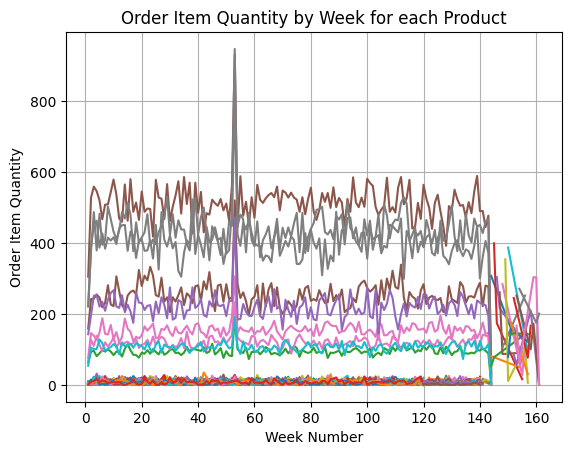

In [82]:
for product_card_id in grouped_data['product_card_id'].unique():
    product_data = grouped_data[grouped_data['product_card_id'] == product_card_id]
    plt.plot(product_data['week_number'], product_data['order_item_quantity'], label=product_card_id)

plt.xlabel('Week Number')
plt.ylabel('Order Item Quantity')
plt.title('Order Item Quantity by Week for each Product')
# plt.legend(title='Product Card ID')
plt.grid(True)

# Show plot
plt.show()

In [83]:
grouped_data_category = SCData.groupby(['product_category_id', 'week_number'])['order_item_quantity'].sum().reset_index()
grouped_data_category

,product_category_id,week_number,order_item_quantity
0,2,120,4
1,2,121,10
2,2,122,25
3,2,123,7
4,2,124,16
...,...,...,...
3513,75,160,304
3514,75,161,1
3515,76,154,272
3516,76,160,176


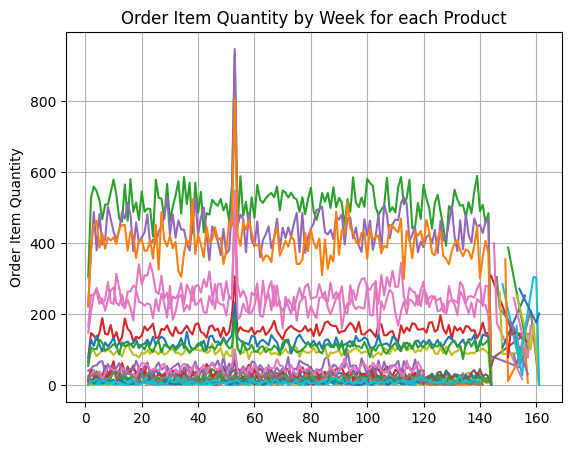

In [84]:
for product_category_id in grouped_data_category['product_category_id'].unique():
    product_data = grouped_data_category[grouped_data_category['product_category_id'] == product_category_id]
    plt.plot(product_data['week_number'], product_data['order_item_quantity'], label=product_category_id)

plt.xlabel('Week Number')
plt.ylabel('Order Item Quantity')
plt.title('Order Item Quantity by Week for each Product')
# plt.legend(title='Product Card ID')
plt.grid(True)

# Show plot
plt.show()

## Group by product_category_id

In [85]:
# Grouping by product_category_id and counting unique week numbers
category_week_counts = grouped_data_category.groupby('product_category_id')['week_number'].nunique()

# Finding the product category with the highest count of unique week numbers
max_week_count_category = category_week_counts.max()
max_week_count_category_id = category_week_counts.idxmax()

print(max_week_count_category_id, max_week_count_category)

9 144


In [113]:
grouped_data_card = SCData.groupby(['product_card_id', 'week_number'])['order_item_quantity'].sum().reset_index()
grouped_data_card

# Grouping by product_category_id and counting unique week numbers
card_week_counts = grouped_data_card.groupby('product_card_id')['week_number'].nunique()

# Finding the product category with the highest count of unique week numbers
max_week_count_card = card_week_counts.max()
max_week_count_card_id = card_week_counts.idxmax()

print(max_week_count_card_id, max_week_count_card)

191 144


In [114]:
grouped_data_category_date = SCData.groupby(['product_category_id', 'order_date'])['order_item_quantity'].sum().reset_index()
grouped_data_category_date

,product_category_id,order_date,order_item_quantity
0,2,2017-04-23,4
1,2,2017-04-24,1
2,2,2017-04-26,1
3,2,2017-04-27,1
4,2,2017-04-28,4
...,...,...,...
17705,76,2018-01-27,68
17706,76,2018-01-28,69
17707,76,2018-01-29,68
17708,76,2018-01-30,69


In [115]:
def get_data(grouped_data, selected_field, selected_value, date_field, days):
    grouped_data = grouped_data[grouped_data[selected_field] == selected_value]
    latest_date = grouped_data[date_field].max()
    split_date = latest_date - timedelta(days=days)

    train_data = grouped_data_category_date[grouped_data_category_date[date_field] < split_date]
    test_data = grouped_data_category_date[grouped_data_category_date[date_field] >= split_date]

    train_data = train_data[train_data[selected_field] == selected_value]
    train_data.set_index(date_field, inplace=True)
    test_data = test_data[test_data[selected_field] == selected_value]
    test_data.set_index(date_field, inplace=True)

    actual_data = grouped_data_category_date[grouped_data_category_date[selected_field] == selected_value]
    actual_data.set_index(date_field, inplace=True)

    train_data = train_data.drop([selected_field], axis=1)
    test_data = test_data.drop([selected_field], axis=1)
    actual_data = actual_data.drop([selected_field], axis=1)

    return train_data, test_data, actual_data

In [116]:
train_data_9, test_data_9, actual_data_9 = get_data(grouped_data_category_date, 'product_category_id', 9, 'order_date', 90)

In [117]:
test_data_9

,order_item_quantity
order_date,
2017-07-04,42
2017-07-05,36
2017-07-06,42
2017-07-07,49
2017-07-08,16
...,...
2017-09-28,51
2017-09-29,30
2017-09-30,32


In [133]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

def forecast_plot(fcast, color, start_date):
    forecast_index = pd.date_range(start=start_date, periods=len(fcast), freq='D')
    forecast_df = pd.DataFrame({'Forecast': fcast.values}, index=forecast_index)
    plt.plot(forecast_df, color=color)
    plt.axvline(x=pd.to_datetime(start_date), color='red', linestyle='--', label='Start test date')

def forecast_diff(fcast, color, start_date, y_to_test):
    forecast_index = pd.date_range(start=start_date, periods=len(fcast), freq='D')
    forecast_df = pd.DataFrame({'Forecast': fcast.values}, index=forecast_index)
    forecast_df.rename(columns={'Forecast': 'order_item_quantity'}, inplace=True)
    forecast_df.index.name = 'order_date'
    diff = y_to_test - forecast_df
    print(diff)
    plt.plot(diff, color=color)

def y_test_change(fcast, y_test):
    df1 = y_test
    df2 = fcast

    if len(df2) > len(df1):
        df2 = df2[:len(df1)]
    elif len(df2) < len(df1):
        raise ValueError('The length of the series in data2 is shorter than the length of data1')

    df2.index = df1.index
    df1 = pd.Series(df1['order_item_quantity'])
    return df1, df2

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date, start_date):
    y.plot(color='black', legend=True, figsize=(16, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    line1, = plt.plot(fit1.fittedvalues, color="blue")
    forecast_plot(fcast1, "blue", start_date)
    forecast_diff(fcast1, "blue", start_date, y_to_test)
    y_to_test_1, fcast1 = y_test_change(fcast1, y_to_test)
    mse1 = ((fcast1 - y_to_test_1) ** 2).mean()
    print('The RMSE of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    line2, = plt.plot(fit2.fittedvalues, color="red")
    forecast_plot(fcast2, "red", start_date)
    y_to_test_2, fcast2 = y_test_change(fcast2, y_to_test)
    mse2 = ((fcast2 - y_to_test_2) ** 2).mean()
    print('The RMSE of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.legend([line1, line2], [fcast1.name, fcast2.name])
    plt.show()

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date, start_date):
    y.plot(color='black', legend=True, figsize=(16, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    forecast_plot(fcast1, "blue", start_date)
    y_to_test_1, fcast1 = y_test_change(fcast1, y_to_test)
    mse1 = ((fcast1 - y_to_test_1) ** 2).mean()
    print('The RMSE of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    forecast_plot(fcast2, "red", start_date)
    y_to_test_2, fcast2 = y_test_change(fcast2, y_to_test)
    mse2 = ((fcast2 - y_to_test_2) ** 2).mean()
    print('The RMSE of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    line1, = plt.plot(fit1.fittedvalues, color="blue")
    line2, = plt.plot(fit2.fittedvalues, color="red")
    plt.legend([line1, line2], [fcast1.name, fcast2.name])
    plt.show()

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date, start_date):
    
    y.plot(color='black', legend=True, figsize=(16, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', use_boxcox=True).fit()
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        forecast_plot(fcast1, "blue", start_date)
        y_to_test_1, fcast1 = y_test_change(fcast1, y_to_test)
        mse1 = ((fcast1 - y_to_test_1) ** 2).mean()
        print('The RMSE of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True, use_boxcox=True).fit()
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        forecast_plot(fcast2, "red", start_date)
        y_to_test_2, fcast2 = y_test_change(fcast2, y_to_test)
        mse2 = ((fcast2 - y_to_test_2) ** 2).mean()
        print('The RMSE of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        line1, = plt.plot(fit1.fittedvalues, color="blue")
        line2, = plt.plot(fit2.fittedvalues, color="red")
        plt.legend([line1, line2], [fcast1.name, fcast2.name])
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', use_boxcox=True).fit()
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        forecast_plot(fcast3, "blue", start_date)
        y_to_test_3, fcast3 = y_test_change(fcast3, y_to_test)
        mse3 = ((fcast3 - y_to_test_3) ** 2).mean()
        print('The RMSE of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True, use_boxcox=True).fit()
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        forecast_plot(fcast4, "red", start_date)
        y_to_test_4, fcast4 = y_test_change(fcast4, y_to_test)
        mse4 = ((fcast4 - y_to_test_4) ** 2).mean()
        print('The RMSE of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        line3, = plt.plot(fit3.fittedvalues, color="blue")
        line4, = plt.plot(fit4.fittedvalues, color="red")
        plt.legend([line3, line4], [fcast3.name, fcast4.name])
        
    else:
         print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

            order_item_quantity
order_date                     
2017-07-04             4.767719
2017-07-05            -1.232281
2017-07-06             4.767719
2017-07-07            11.767719
2017-07-08           -21.232281
...                         ...
2017-09-28            13.767719
2017-09-29            -7.232281
2017-09-30            -5.232281
2017-10-01             8.767719
2017-10-02           -19.232281

[91 rows x 1 columns]
The RMSE of our forecasts with smoothing level of 0.8 is 13.13
The RMSE of our forecasts with auto optimization is 13.25


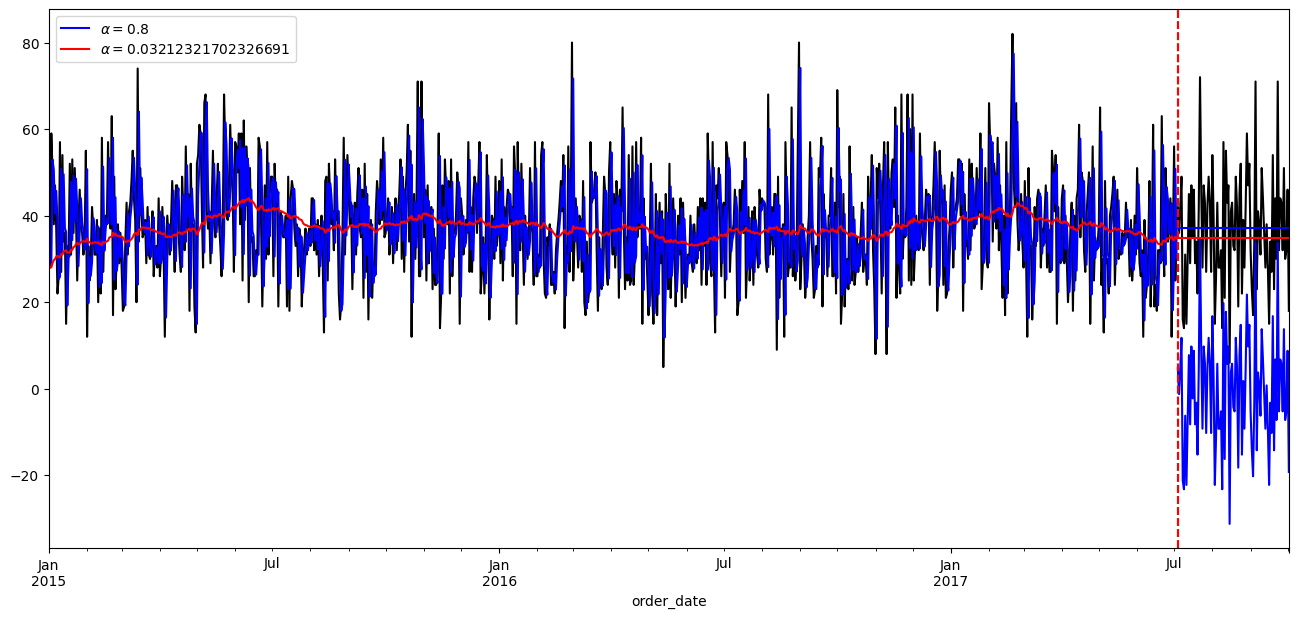

In [134]:
ses(actual_data_9, train_data_9, test_data_9, 0.8, 91, '2017-07-04')

The RMSE of Holts Linear trend 14.61
The RMSE of Holts Exponential trend 762.47


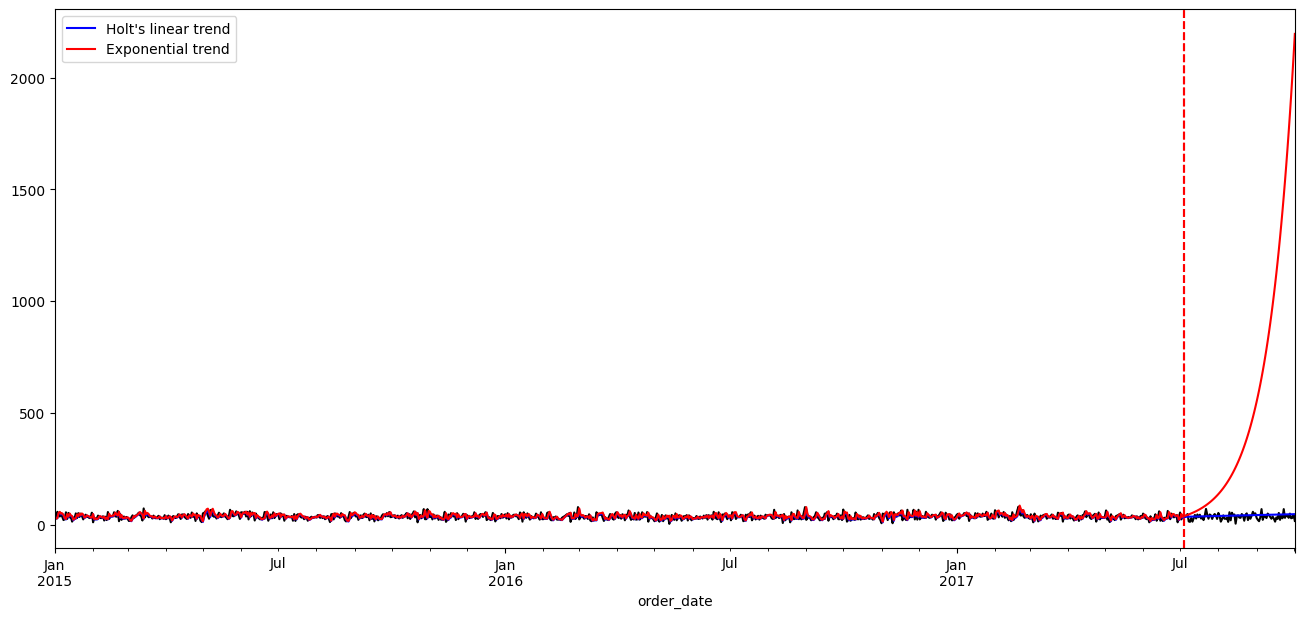

In [93]:
holt(actual_data_9, train_data_9, test_data_9,0.6,0.2,91, '2017-07-04')

The RMSE of additive trend, additive seasonal of period season_length=52 and a Box-Cox transformation 13.05
The RMSE of additive damped trend, additive seasonal of period season_length=52 and a Box-Cox transformation 13.0


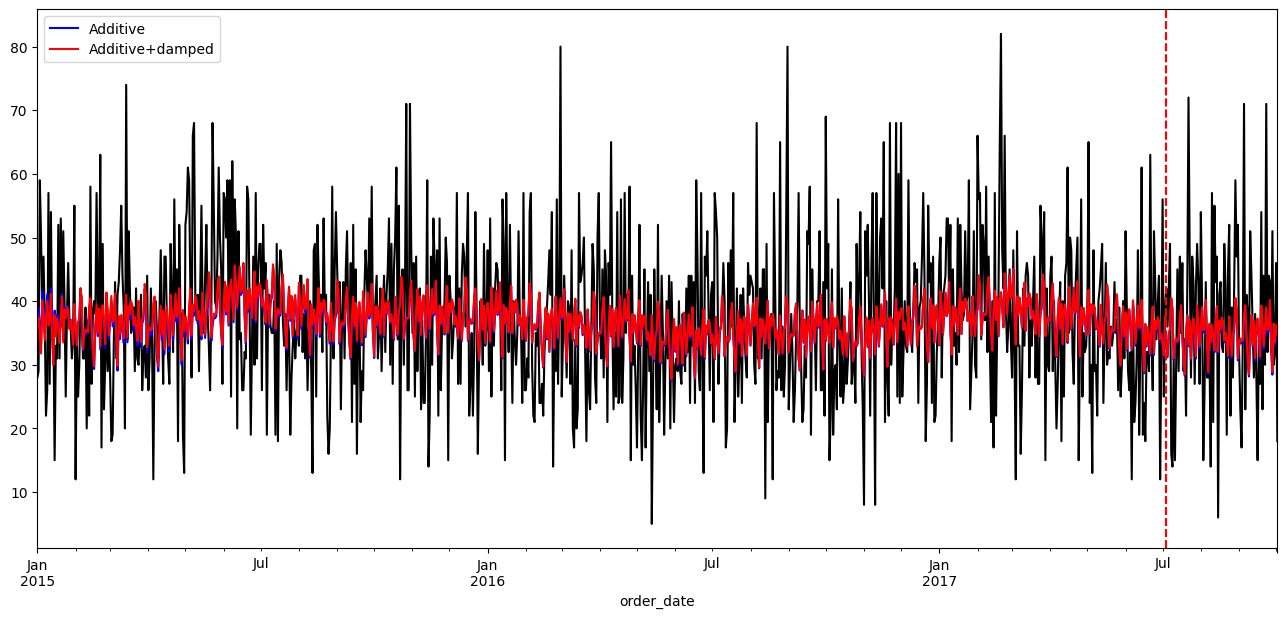

In [94]:
holt_win_sea(actual_data_9, train_data_9, test_data_9,'additive', 52, 91, '2017-07-04')

The RMSE of additive trend, multiplicative seasonal of period season_length=52 and a Box-Cox transformation 13.07
The RMSE of additive damped trend, multiplicative seasonal of period season_length=52 and a Box-Cox transformation 13.05


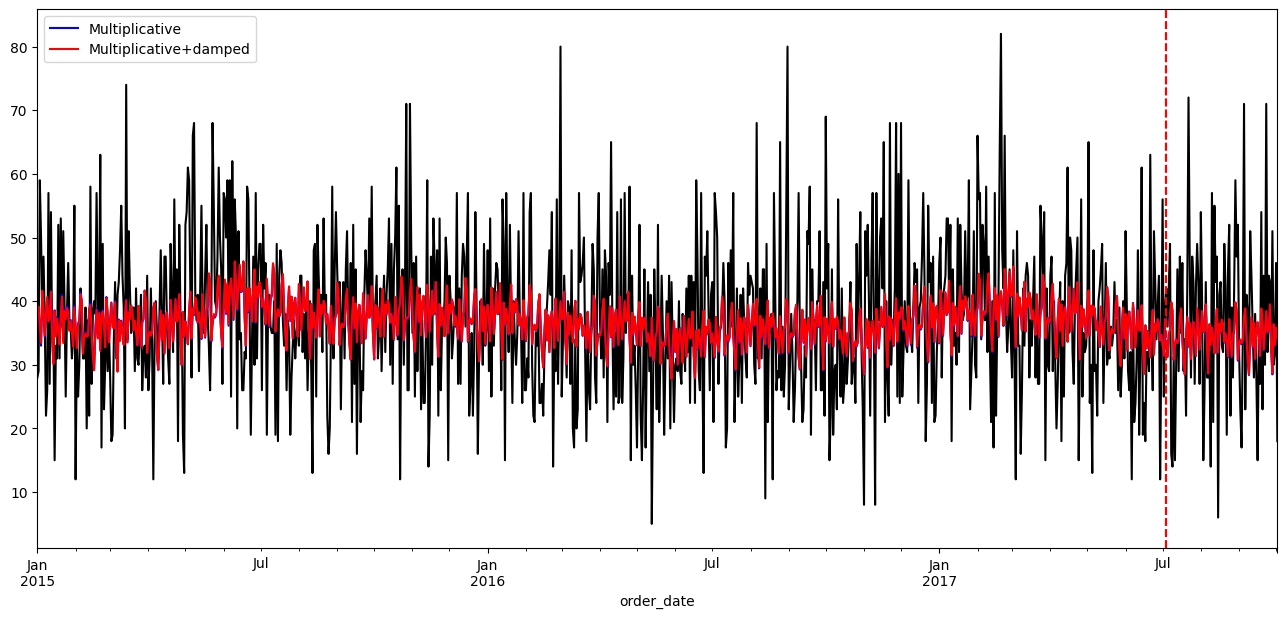

In [95]:
holt_win_sea(actual_data_9, train_data_9, test_data_9,'multiplicative', 52, 91, '2017-07-04')

### 6 Month

In [96]:
grouped_data_category_date = grouped_data_category_date[grouped_data_category_date['product_category_id'] == 9]
latest_date = grouped_data_category_date['order_date'].max()
cutoff_date = latest_date - pd.DateOffset(months=6)
filtered_df = grouped_data_category_date[grouped_data_category_date['order_date'] >= cutoff_date]
split_date = latest_date - timedelta(days=30)

train_data = filtered_df[filtered_df['order_date'] < split_date]
test_data = filtered_df[filtered_df['order_date'] >= split_date]

train_data_9 = train_data[train_data['product_category_id'] == 9]
train_data_9.set_index('order_date', inplace=True)
test_data_9 = test_data[test_data['product_category_id'] == 9]
test_data_9.set_index('order_date', inplace=True)

actual_data_9 = filtered_df[filtered_df['product_category_id'] == 9]
actual_data_9.set_index('order_date', inplace=True)

train_data_9 = train_data_9.drop(['product_category_id'], axis=1)
test_data_9 = test_data_9.drop(['product_category_id'], axis=1)
actual_data_9 = actual_data_9.drop(['product_category_id'], axis=1)

In [97]:
train_data_9

,order_item_quantity
order_date,
2017-04-02,47
2017-04-03,29
2017-04-04,40
2017-04-05,30
2017-04-06,20
...,...
2017-08-28,42
2017-08-29,59
2017-08-30,47


In [98]:
test_data_9

,order_item_quantity
order_date,
2017-09-02,23
2017-09-03,17
2017-09-04,34
2017-09-05,71
2017-09-06,23
2017-09-07,41
2017-09-08,38
2017-09-09,31
2017-09-10,51


The RMSE of our forecasts with smoothing level of 0.8 is 13.44
The RMSE of our forecasts with auto optimization is 13.63


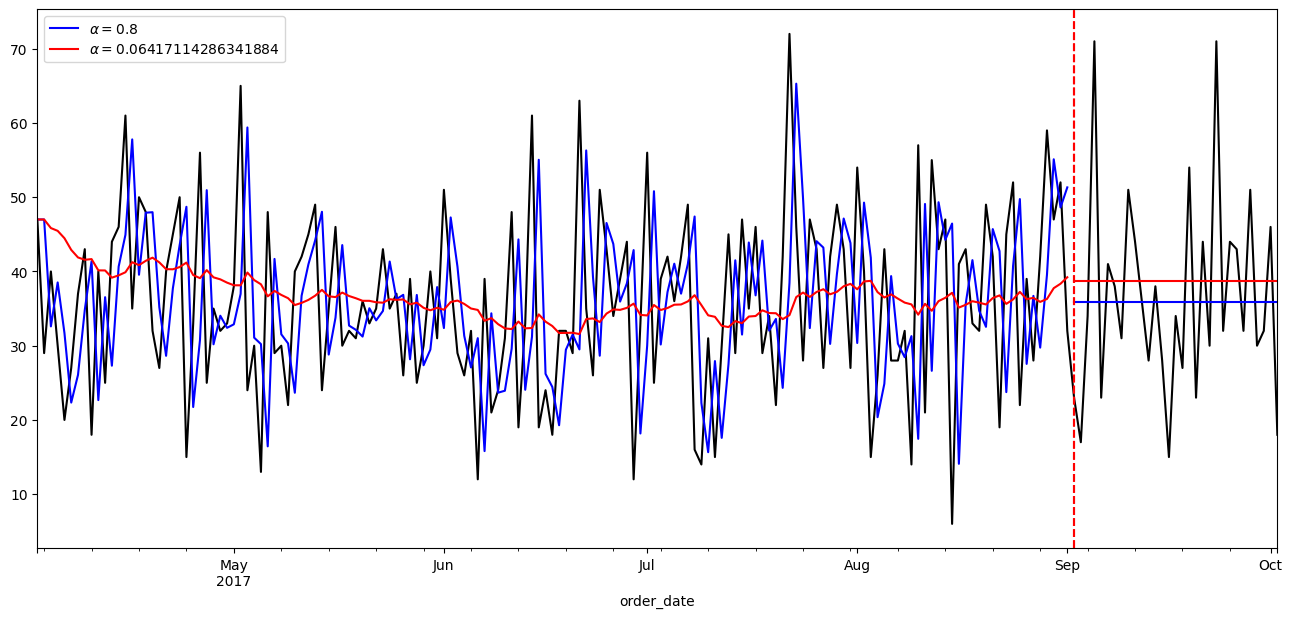

In [99]:
ses(actual_data_9, train_data_9, test_data_9, 0.8, 31, '2017-09-02')

The RMSE of Holts Linear trend 14.79
The RMSE of Holts Exponential trend 20.73


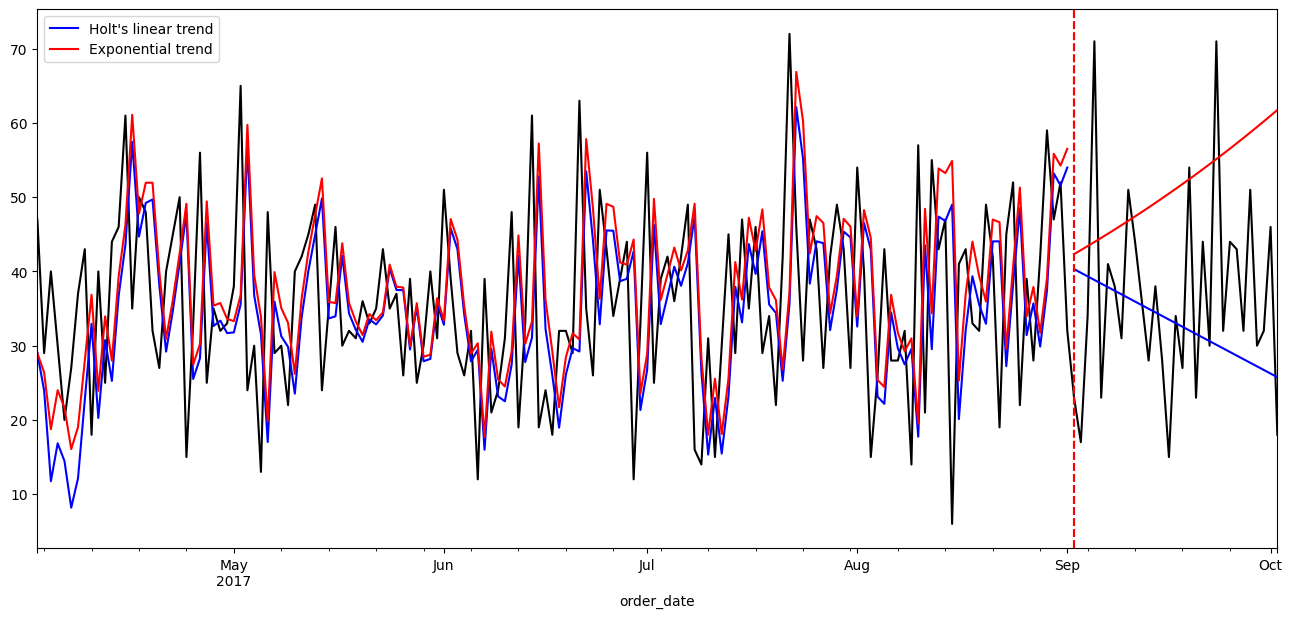

In [100]:
holt(actual_data_9, train_data_9, test_data_9,0.6,0.2,31, '2017-09-02')

The RMSE of additive trend, additive seasonal of period season_length=4 and a Box-Cox transformation 13.05
The RMSE of additive damped trend, additive seasonal of period season_length=4 and a Box-Cox transformation 13.11


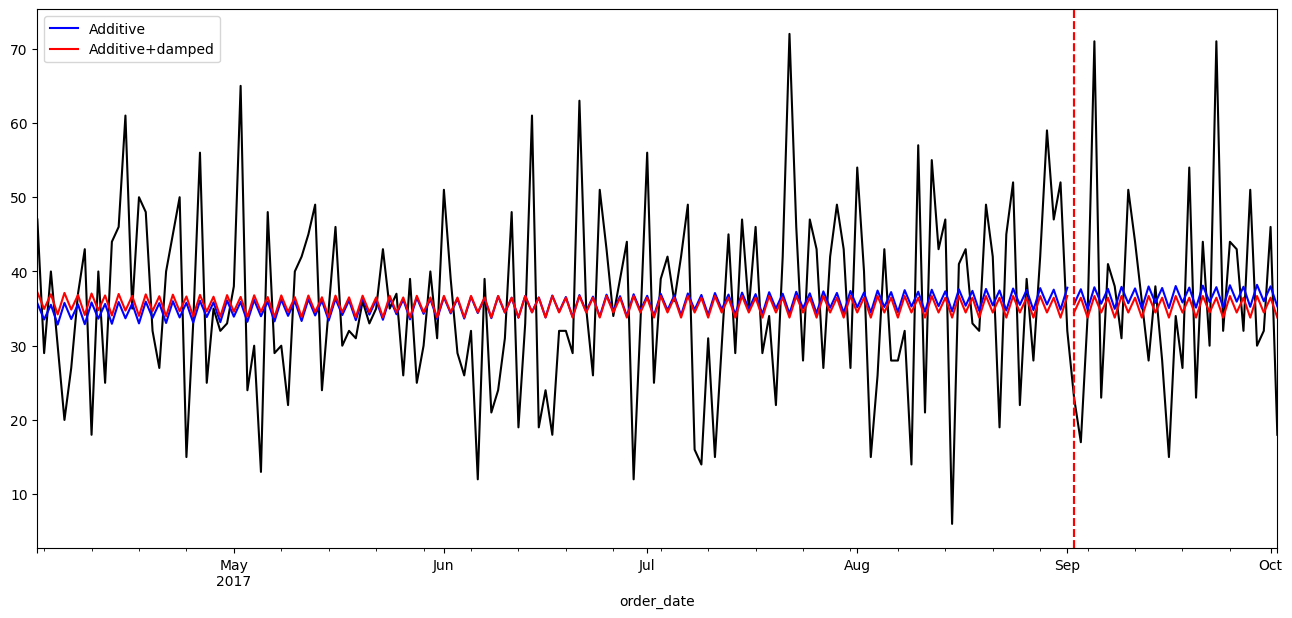

In [101]:
holt_win_sea(actual_data_9, train_data_9, test_data_9,'additive', 4, 31, '2017-09-02')

The RMSE of additive trend, multiplicative seasonal of period season_length=4 and a Box-Cox transformation 13.04
The RMSE of additive damped trend, multiplicative seasonal of period season_length=4 and a Box-Cox transformation 13.1


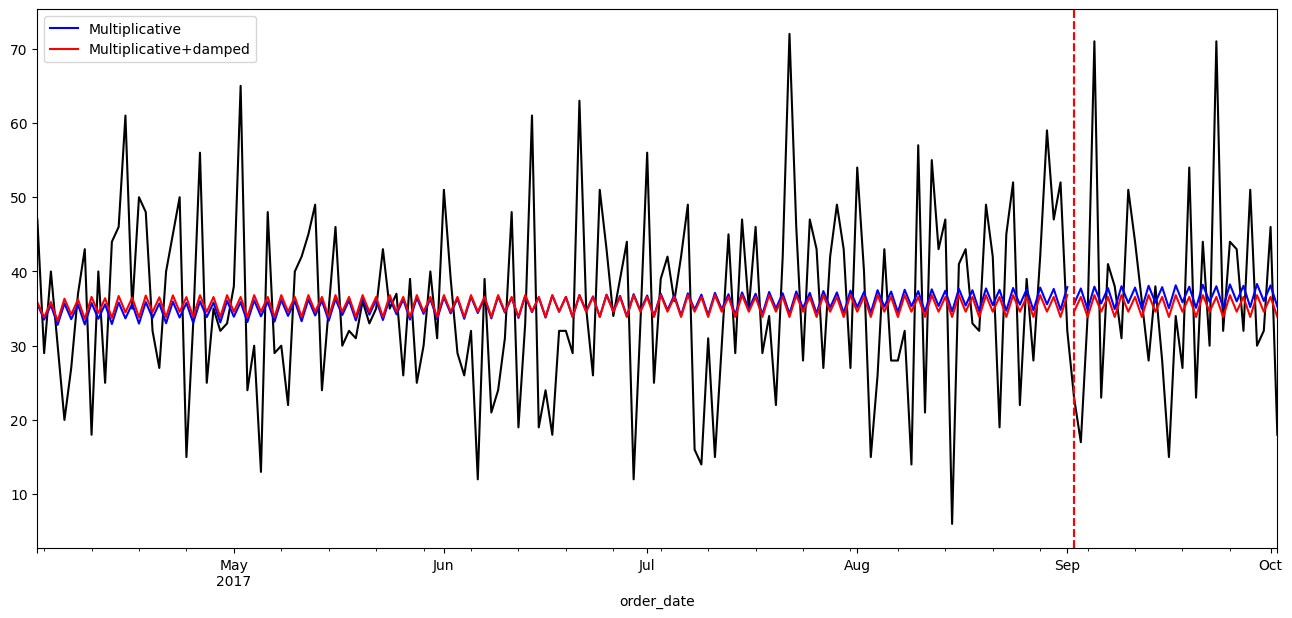

In [102]:
holt_win_sea(actual_data_9, train_data_9, test_data_9,'multiplicative', 4, 31, '2017-09-02')

## Card ID

In [103]:
grouped_data_card_date = SCData.groupby(['product_card_id', 'order_date'])['order_item_quantity'].sum().reset_index()
grouped_data_card_date

,product_card_id,order_date,order_item_quantity
0,19,2017-04-24,1
1,19,2017-04-26,1
2,19,2017-05-03,1
3,19,2017-05-04,1
4,19,2017-05-06,1
...,...,...,...
22268,1363,2018-01-27,68
22269,1363,2018-01-28,69
22270,1363,2018-01-29,68
22271,1363,2018-01-30,69


In [104]:
def get_data_card(grouped_data, selected_field, selected_value, date_field, days):
    grouped_data = grouped_data[grouped_data[selected_field] == selected_value]
    # latest_date = grouped_data[date_field].max()
    # split_date = latest_date - timedelta(days=days)

    # train_data = grouped_data_card_date[grouped_data_card_date[date_field] < split_date]
    # test_data = grouped_data_card_date[grouped_data_card_date[date_field] >= split_date]

    train_data =  grouped_data[grouped_data[date_field].dt.isocalendar().year != 2017]
    test_data =  grouped_data[grouped_data[date_field].dt.isocalendar().year == 2017]

    train_data = train_data[train_data[selected_field] == selected_value]
    train_data.set_index(date_field, inplace=True)
    test_data = test_data[test_data[selected_field] == selected_value]
    test_data.set_index(date_field, inplace=True)

    actual_data = grouped_data_card_date[grouped_data_card_date[selected_field] == selected_value]
    actual_data.set_index(date_field, inplace=True)

    train_data = train_data.drop([selected_field], axis=1)
    test_data = test_data.drop([selected_field], axis=1)
    actual_data = actual_data.drop([selected_field], axis=1)

    return train_data, test_data, actual_data

In [105]:
train_data_365, test_data_365, actual_data_365 = get_data_card(grouped_data_card_date, 'product_card_id', 365, 'order_date', 90)

In [106]:
test_data_365

,order_item_quantity
order_date,
2017-01-02,92
2017-01-03,52
2017-01-04,54
2017-01-05,52
2017-01-06,83
...,...
2017-09-28,41
2017-09-29,38
2017-09-30,90


The RMSE of additive trend, additive seasonal of period season_length=4 and a Box-Cox transformation 16.58
The RMSE of additive damped trend, additive seasonal of period season_length=4 and a Box-Cox transformation 16.47


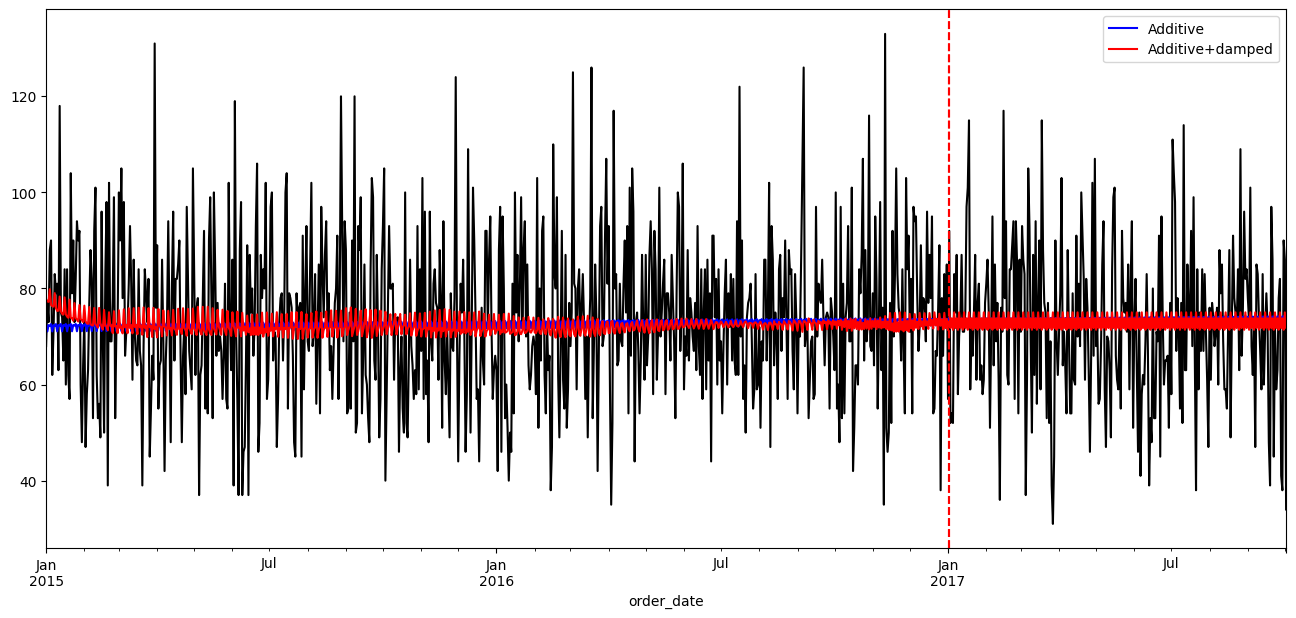

In [107]:
holt_win_sea(actual_data_365, train_data_365, test_data_365,'additive', 4, 275, '2017-01-02')

The RMSE of additive trend, multiplicative seasonal of period season_length=4 and a Box-Cox transformation 16.58
The RMSE of additive damped trend, multiplicative seasonal of period season_length=4 and a Box-Cox transformation 16.5


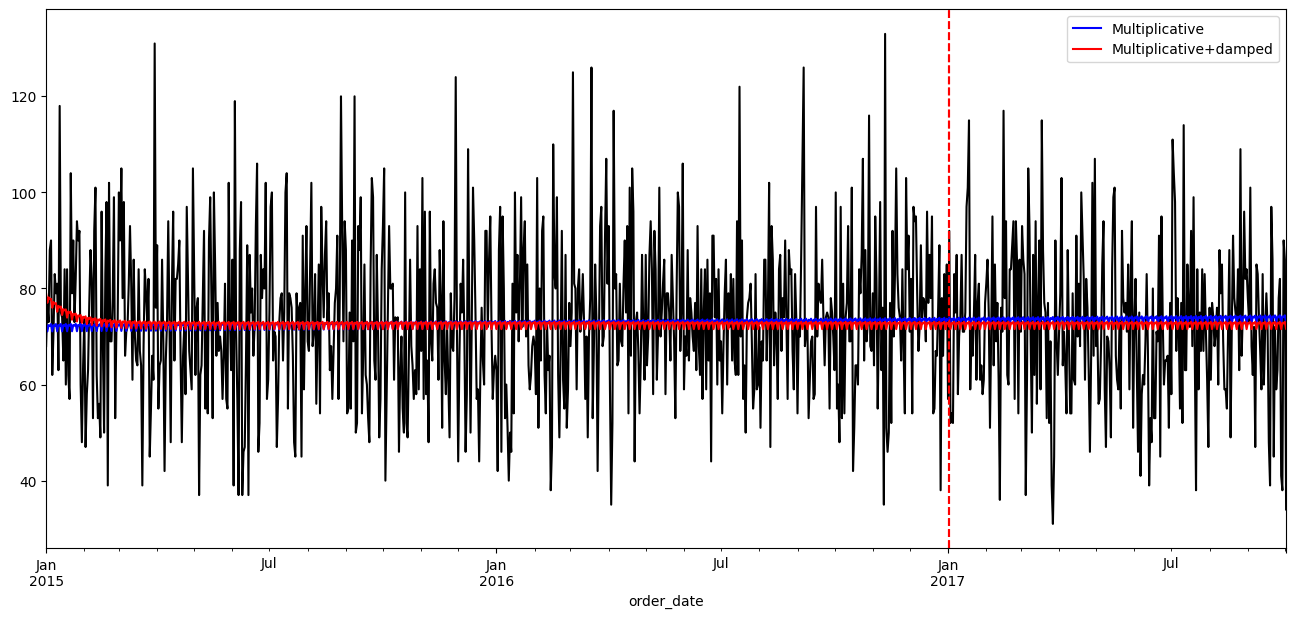

In [108]:
holt_win_sea(actual_data_365, train_data_365, test_data_365,'multiplicative', 4, 275, '2017-01-02')

In [109]:
def plot_graph(result_df, train_df):    
    plt.figure(figsize=(30, 6))
    plt.plot(result_df['order_date'], result_df['Actual'], color='blue', marker='.', linestyle='-', label='Trend Line')
    plt.plot(result_df['order_date'], result_df['Predict'], color='red', marker='.', linestyle='-', label='Trend Line')
    plt.plot(train_df['order_date'], train_df['order_item_quantity'], color='blue', marker='.', linestyle='-', label='Trend Line')
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(30, 6))
    plt.plot(result_df['order_date'], result_df['Actual'], color='blue', marker='.', linestyle='-', label='Trend Line')
    plt.plot(result_df['order_date'], result_df['Predict'], color='red', marker='.', linestyle='-', label='Trend Line')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(30, 6))
    plt.plot(result_df['order_date'],result_df['Predict']-result_df['Actual'], color='blue', marker='.', linestyle='-', label='Trend Line')
    plt.axhline(y=0, color='black', linestyle='-', label='Ref Line')
    plt.grid(True)
    plt.legend() 
    plt.show()


    plt.figure(figsize=(30, 6))
    plt.plot(result_df['order_date'], (abs(result_df['Predict'] - result_df['Actual']) / result_df['Actual']) * 100, color='blue', marker='.', linestyle='-', label='Trend Line')
    plt.grid(True)
    plt.legend() 
    plt.ylim(1, 100)
    plt.show()